## Notes 
- Comment choisir la longueur maximal de la sentence 
- use [this](https://www.analyticsvidhya.com/blog/2021/05/bert-for-natural-language-inference-simplified-in-pytorch/)

In [1]:
from datasets import load_dataset, Dataset
from helper import translate_fr_en
import evaluate
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
%load_ext autoreload
%autoreload 2
print(torch.cuda.is_available(),torch.cuda.current_device())
# torch.cuda.device(1)
# torch.cuda.get_device_name(0)

model_name = {}
model_name['fr'] = 'camembert-base'
model_name['en'] = 'roberta-base'
dataset_name = {}
dataset_name['fr'] = 'xnli'
dataset_name['en'] = 'xnli'


data_path = '/data/desponds/data/NLI/'

True 0


In [2]:
dataset_en = load_dataset(dataset_name['en'], 'en')
dataset_fr = load_dataset(dataset_name['fr'], 'fr')

tokenizer = {}
tokenizer['fr'] = AutoTokenizer.from_pretrained(model_name['fr'])
tokenizer['en'] = AutoTokenizer.from_pretrained(model_name['en'])

model = {}
model['fr'] = AutoModelForSequenceClassification.from_pretrained(model_name['fr'], num_labels=3)
model['en'] = AutoModelForSequenceClassification.from_pretrained(model_name['en'], num_labels=3)

Found cached dataset xnli (/home/desponds/.cache/huggingface/datasets/xnli/en/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset xnli (/home/desponds/.cache/huggingface/datasets/xnli/fr/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

## Looking at the dataset

In [4]:
cls_token_idx = tokenizer['fr'].cls_token_id
sep_token_idx = tokenizer['fr'].sep_token_id
pad_token_idx = tokenizer['fr'].pad_token_id
unk_token_idx = tokenizer['fr'].unk_token_id
print(cls_token_idx, sep_token_idx, pad_token_idx, unk_token_idx)
cls_token = tokenizer['fr'].cls_token
sep_token = tokenizer['fr'].sep_token
pad_token = tokenizer['fr'].pad_token
unk_token = tokenizer['fr'].unk_token
print(cls_token, sep_token, pad_token, unk_token)

5 6 1 4
<s> </s> <pad> <unk>


In [5]:
# Check if dataset is balanced 
from collections import Counter 
c = Counter(dataset_fr['train']['label'])
c2 = Counter(dataset_en['train']['label'])
c.most_common(), c2.most_common()

([(2, 130903), (1, 130900), (0, 130899)],
 [(2, 130903), (1, 130900), (0, 130899)])

Loading cached processed dataset at /home/desponds/.cache/huggingface/datasets/xnli/fr/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd/cache-9b25419c8a552827.arrow


(array([3.45701e+05, 4.37360e+04, 2.60800e+03, 4.29000e+02, 1.29000e+02,
        4.80000e+01, 4.20000e+01, 3.00000e+00, 3.00000e+00, 3.00000e+00]),
 array([  1. ,  43.5,  86. , 128.5, 171. , 213.5, 256. , 298.5, 341. ,
        383.5, 426. ]),
 <BarContainer object of 10 artists>)

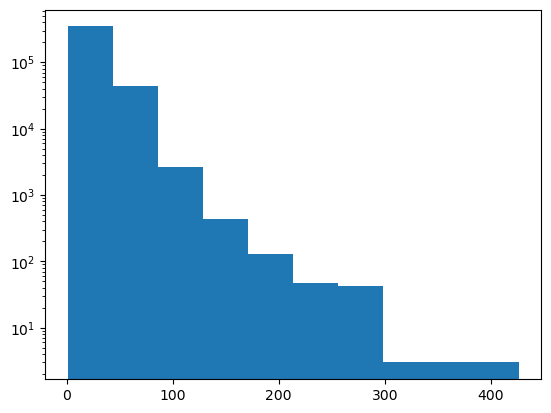

In [6]:
import matplotlib.pyplot as plt
import numpy as np 
plt.hist(dataset_fr['train'].map(lambda ex : {'maxlength' : max(len(ex['premise'].split(' ')),len(ex['hypothesis'].split(' ')) )})['maxlength'], log =True)

## Preapring for training

In [3]:
# Set the metric to accuracy for the training
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [4]:
# dataset_fr['train'] = dataset_fr['train'].shuffle(seed =42).select(range(100000))

In [4]:
from torch.nn.utils.rnn import pad_sequence
MAX_LENGTH = 256 

# def preprocess(example, language):
#     def truncate(example, max_length = MAX_LENGTH) : 
#         if len(example['premise']) > MAX_LENGTH - 2 :
#             example['premise'] = example['premise'][:MAX_LENGTH - 2]
#         if len(example['hypothesis']) > MAX_LENGTH - 1 :
#             example['hypothesis'] = example['hypothesis'][:MAX_LENGTH - 1]
#         return example
#     def pad(data, max_length = MAX_LENGTH):
#         return data + [tokenizer[language].pad_token_id] * (2*MAX_LENGTH-len(data))
    
#     pre_tok = tokenizer[language](
#         f"{tokenizer[language].cls_token} {example['premise']} {tokenizer[language].cls_token}",
#         max_length = MAX_LENGTH,
#         truncation = True)['input_ids']
#     hyp_tok = tokenizer[language](f"{example['hypothesis']} {tokenizer[language].cls_token}",
#         max_length = MAX_LENGTH,
#         truncation = True)['input_ids']
#     len_pre, len_hyp = len(pre_tok), len(hyp_tok)
# #     print(pre_tok + hyp_tok + [tokenizer[language].pad_token])
#     example['label'] = example['label']-1
#     example['input_ids'] = pad(pre_tok + hyp_tok )
#     example['attention_mask'] = pad([1]*(len_pre+len_hyp))
#     example['token_type_ids'] = pad([0]*len_pre+[1]*len_hyp)
#     return example
def preprocess2(example, language):
    out = tokenizer[language](example['premise'], example['hypothesis'], max_length = MAX_LENGTH, padding = 'max_length',
        truncation = 'only_first')
    out['label'] = example['label']  
    return out
                                  
tokenized_fr = dataset_fr.map(lambda ex : preprocess2(ex, 'fr'))  
tokenized_fr = tokenized_fr.remove_columns(['premise', 'hypothesis'])

tokenized_en = dataset_en.map(lambda ex : preprocess2(ex, 'en'))
tokenized_en = tokenized_en.remove_columns(['premise', 'hypothesis'])

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [5]:
def get_training_args(language):
    return TrainingArguments(
        output_dir=data_path+ 'trainer_'+language,
        overwrite_output_dir = True,
        evaluation_strategy="no",
        learning_rate=2e-5,
        num_train_epochs=3,
        weight_decay=0.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        save_strategy = 'epoch',
        logging_steps = 100,
        report_to='tensorboard'
    )
def get_trainer(dataset, language):
    return Trainer(
        model=model[language],
        args=training_args[language],
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        tokenizer=tokenizer[language],
        compute_metrics = compute_metrics)

training_args = {}
# training_args['fr'] = get_training_args('fr')
training_args['en'] = get_training_args('en')
trainer = {}
# trainer['fr'] = get_trainer(tokenized_fr, 'fr')
trainer['en'] = get_trainer(tokenized_en, 'en')

In [7]:
trainer['fr'].train(data_path+'trainer_fr/checkpoint-36816')

Loading model from /data/desponds/data/NLI/trainer_fr/checkpoint-36816.
/data/desponds/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 392702
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 36816
  Number of trainable parameters = 110624259
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 3
  Continuing training from global step 36816
  Will skip the first 3 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your la

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=36816, training_loss=0.0, metrics={'train_runtime': 0.3948, 'train_samples_per_second': 2983917.591, 'train_steps_per_second': 93247.9, 'total_flos': 1.549877480529316e+17, 'train_loss': 0.0, 'epoch': 3.0})

In [6]:
trainer['en'].train(data_path+'trainer_en/checkpoint-36816')

Loading model from /data/desponds/data/NLI/trainer_en/checkpoint-36816.
/data/desponds/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 392702
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 36816
  Number of trainable parameters = 124647939
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 3
  Continuing training from global step 36816
  Will skip the first 3 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your la

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=36816, training_loss=0.0, metrics={'train_runtime': 0.3604, 'train_samples_per_second': 3268986.563, 'train_steps_per_second': 102156.35, 'total_flos': 1.549877480529316e+17, 'train_loss': 0.0, 'epoch': 3.0})

## Translation

In [20]:
def translate_fr_en_nli(examples):
    examples['premise'] = translate_fr_en(examples['premise'])
    examples['hypothesis'] = translate_fr_en(examples['hypothesis'])
    return examples

# Translate the test split of the french dataset
translated_fr_en = dataset_fr['test'].map(translate_fr_en_nli, batched=True, batch_size = 32)

import pickle
with open(f"{data_path}translated_dataset.pickle", 'wb') as handle:
    pickle.dump(translated_fr_en, handle)

Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

/data/desponds/anaconda3/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 595

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

32


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

18


Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_t

18


In [ ]:
import pickle
with open(data_path+"translated_dataset.pickle", 'rb') as handle:
    translated_fr_en = pickle.load(handle)

In [21]:
tokenized_fr_en = translated_fr_en.map(lambda ex : preprocess2(ex,'en'))


Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

## Evaluation

### Dataset FR with CamemBERT

In [19]:
import numpy as np
logits,labels, test = trainer['fr'].predict(tokenized_fr['test'])
print(test) 

***** Running Prediction *****
  Num examples = 5010
  Batch size = 32
/data/desponds/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.508586049079895, 'test_accuracy': 0.8161676646706587, 'test_runtime': 34.9684, 'test_samples_per_second': 143.272, 'test_steps_per_second': 4.49}


### Dataset EN with RoBERTa

In [20]:
logits,labels, test = trainer['en'].predict(tokenized_en['test'])
print(test) 

***** Running Prediction *****
  Num examples = 5010
  Batch size = 32
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/data/desponds/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.37602242827415466, 'test_accuracy': 0.880439121756487, 'test_runtime': 36.686, 'test_samples_per_second': 136.564, 'test_steps_per_second': 4.28}


### Dataset FR with RoBERTa

In [24]:
import numpy as np
logits,labels, test = trainer['en'].predict(tokenized_fr_en)
print(test)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: premise, hypothesis. If premise, hypothesis are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5010
  Batch size = 32
/data/desponds/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.6378116011619568, 'test_accuracy': 0.8099800399201597, 'test_runtime': 36.2586, 'test_samples_per_second': 138.174, 'test_steps_per_second': 4.33}


## Results

In [25]:
import pandas as pd
data = {
    'task' : ['NLI', 'NLI', 'NLI'],
    'train_dataset' : ['xnli_fr', 'xnli_en', 'xnli_en'],
    'nb_sample_train_dataset' : [392702,392702,392702],
    'test_dataset' : ['xnli_fr', 'xnli_en', 'xnli_fr_translated'],
    'translated' : ['no', 'no', 'yes'],
    'model'       : ['CamemBERT', 'Roberta', 'Roberta'],
    'accuracy'    : [ 0.816167, 0.880439, 0.80998]
}
results = pd.DataFrame(data)
results

task train_dataset  nb_sample_train_dataset        test_dataset translated  \
0  NLI       xnli_fr                   392702             xnli_fr         no   
1  NLI       xnli_en                   392702             xnli_en         no   
2  NLI       xnli_en                   392702  xnli_fr_translated        yes   

       model  accuracy  
0  CamemBERT  0.816167  
1    Roberta  0.880439  
2    Roberta  0.809980